# Lab 4: TD and Dyna




## Exercise 1: Implement SARSA with n-step TD (n=5) on CliffWalking

**Objective:**  
In this exercise, you will implement the **SARSA algorithm** using **n-step temporal-difference learning with n=5**. You will apply your implementation to the **CliffWalking environment** in Gymnasium, and analyze how multi-step returns influence learning compared to standard 1-step SARSA.

---

### Environment
- Use `CliffWalking-v1`

---

### Instructions
1. Implement **SARSA with n-step TD updates (n=5)**:
   - Maintain an action-value table \(Q(s,a)\).
   - Use ε-greedy exploration.
   - Store states, actions, and rewards for the last 5 steps.
   - After each step, compute the n-step return: G_t
   - Update \(Q(s_t,a_t)\) toward \(G_t\).

2. Train your agent for several thousand episodes (e.g., 5,000).

3. Plot the **episode rewards over time** to visualize learning progress.

4. Compare qualitatively with 1-step SARSA:
   - Does n-step SARSA converge faster or slower?
   - How do the policies differ near the cliff?

---

### Deliverables
- Python code implementing SARSA with TD(5) (notebook in Github).  
- A plot of episode number vs episode return (plot in a cell below).  
- A short discussion (1 paragraph) comparing the results with standard SARSA.  


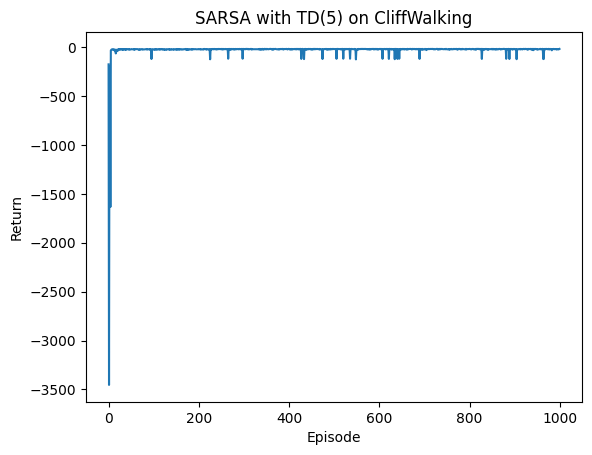

In [15]:
from gymnasium.envs.mujoco.humanoid_v4 import HumanoidEnv

"""
Starter code for Exercise (you can use this code, or extend your code from previous lab)
Implement SARSA with TD(5) on CliffWalking-v1
"""

import numpy as np
if not hasattr(np, "bool8"):
    np.bool8 = np.bool_

import gymnasium as gym
import matplotlib.pyplot as plt

# Environment
env = gym.make("CliffWalking-v1")    # For some reason,my gymnasium does not have CliffWalking-v1

# Parameters
n_states = env.observation_space.n
n_actions = env.action_space.n
alpha = 0.1           # step size (learning rate)
gamma = 0.99          # discount factor
epsilon = 0.1         # epsilon for epsilon-greedy policy
n_step = 5            # number of steps for TD(n)
n_episodes =1000

# Initialize Q-table
Q = np.zeros((n_states, n_actions))

def epsilon_greedy(state):
    """Choose an action using epsilon-greedy policy."""
    if np.random.rand() < epsilon:
        return np.random.randint(n_actions)
    return np.argmax(Q[state])

# Track returns
episode_returns = []

for ep in range(n_episodes):
    state, _ = env.reset()
    action = epsilon_greedy(state)

    # Buffers to store the trajectory
    states = [state]
    actions = [action]
    rewards = [0]

    T = float("inf")
    t = 0
    G = 0
    done = False

    while True:
        if t < T:
            # Take real step in the environment
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            states.append(next_state)
            rewards.append(reward)

            if done:
                T = t + 1
            else:
                next_action = epsilon_greedy(next_state)
                actions.append(next_action)
                state = next_state
                action = next_action

        # Time index for state/action to update
        tau = t - n_step + 1
        if tau >= 0:
            # TODO: Compute the n-step return G for state tau
            # Hint: use rewards[tau : tau+n] plus Q(s_t+n, a_t+n) if not terminal

            # Example structure:
            G = 0.0
            # accumulate discounted rewards
            for i in range(tau + 1, min(tau + n_step + 1, T + 1)):
                G += (gamma ** (i - tau - 1)) * rewards[i]
            if tau + n_step < T:
                s_tau_n = states[tau + n_step]
                a_tau_n = actions[tau + n_step]
                G += (gamma ** n_step) * Q[s_tau_n, a_tau_n]

            # TODO: Update Q[states[tau], actions[tau]] toward G
            Q[states[tau], actions[tau]] += alpha * (G - Q[states[tau], actions[tau]])

        if tau == T - 1:
            break

        t += 1

    episode_returns.append(sum(rewards[1:]))

# Plot learning curve
plt.plot(episode_returns)
plt.xlabel("Episode")
plt.ylabel("Return")
plt.title("SARSA with TD(5) on CliffWalking")
plt.show()


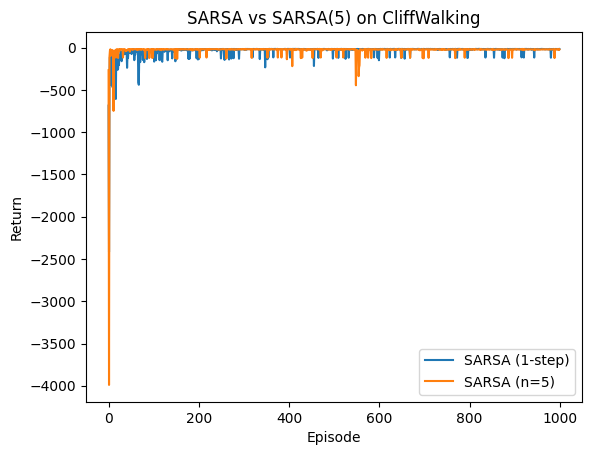

In [16]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

env = gym.make("CliffWalking-v1")

n_states = env.observation_space.n
n_actions = env.action_space.n
alpha = 0.1
gamma = 0.99
epsilon = 0.1
n_step = 5
n_episodes = 1000

def epsilon_greedy(Q, state):
    if np.random.rand() < epsilon:
        return np.random.randint(n_actions)
    return np.argmax(Q[state])

def run_sarsa(Q, n_step=1):
    returns = []
    for ep in range(n_episodes):
        state, _ = env.reset()
        action = epsilon_greedy(Q, state)

        states = [state]
        actions = [action]
        rewards = [0]
        T = float("inf")
        t = 0

        while True:
            if t < T:
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                states.append(next_state)
                rewards.append(reward)

                if done:
                    T = t + 1
                else:
                    next_action = epsilon_greedy(Q, next_state)
                    actions.append(next_action)
                    state = next_state
                    action = next_action

            tau = t - n_step + 1
            if tau >= 0:
                G = 0.0
                for i in range(tau + 1, min(tau + n_step + 1, T + 1)):
                    G += (gamma ** (i - tau - 1)) * rewards[i]
                if tau + n_step < T:
                    s_tau_n = states[tau + n_step]
                    a_tau_n = actions[tau + n_step]
                    G += (gamma ** n_step) * Q[s_tau_n, a_tau_n]
                Q[states[tau], actions[tau]] += alpha * (G - Q[states[tau], actions[tau]])
            if tau == T - 1:
                break
            t += 1

        returns.append(sum(rewards[1:]))
    return returns

Q_sarsa = np.zeros((n_states, n_actions))
Q_sarsa5 = np.zeros((n_states, n_actions))

returns_sarsa = run_sarsa(Q_sarsa, n_step=1)
returns_sarsa5 = run_sarsa(Q_sarsa5, n_step=5)

plt.plot(returns_sarsa, label="SARSA (1-step)")
plt.plot(returns_sarsa5, label="SARSA (n=5)")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.title("SARSA vs SARSA(5) on CliffWalking")
plt.legend()
plt.show()


TD(5) SARSA seems to converge faster than TD(1), and it also works much better and more consistently near the cliff. The policy it learns tends to hug the cliff and take the shortest path to the goal, while the TD(1) policy usually stays farther away to avoid falling. This shows that using multi-step returns helps the agent learn smarter strategies in risky environments, since it can better understand the long-term consequences of its actions.

## Exercise 2: Dyna-Q for CliffWalking

**Objective**  
Implement **Dyna-Q** on **CliffWalking-v1** and compare its learning performance to **SARSA (1-step)** and **SARSA TD(5)**. You will analyze sample efficiency, stability near the cliff, and sensitivity to planning steps.

---

### Environment
- Use `CliffWalking-v1`
---

### Part A — Dyna-Q (Implementation)
1. **Q-table**: maintain `Q[s, a]` (tabular).
2. **Model**: learn an empirical model from experience.
   - For each observed transition `(s, a, r, s')`, update a dictionary:
     - Minimal: store the most recent `(s', r)` for `(s, a)`, **or**
     - Advanced: store a **multiset** of outcomes for `(s, a)` with counts (to sample stochastically).
3. **Real update (Q-learning)** after each env step:
   Q(s,a) ← Q(s,a) + α * (r + γ * max_a' Q(s',a') - Q(s,a))
4. **Planning updates**: after each real step, perform `N` simulated updates:
   - Sample a previously seen `(s_p, a_p)` from the model.
   - Sample `(r_p, s'_p)` from that entry.
   - Apply the same Q-learning backup using `(s_p, a_p, r_p, s'_p)`.
5. Use epsilon-greedy exploration.

---

### Part B — Baselines (Re-use / Implement)
- **SARSA (1-step)** with ε-greedy:
  \[
  Q(s,a) \leftarrow Q(s,a) + \alpha\big[r + \gamma Q(s',a') - Q(s,a)\big]
  \]
- **SARSA TD(5)** (n-step SARSA with \(n=5\)), as in Exercise 1.

Use the **same** γ, α, ε schedule, and number of episodes for a fair comparison.

---

### Part C — Experiments & Comparisons
1. **Learning curves**: plot **episode index vs. episode return** for:
   - Dyna-Q with \(N \in \{5, 20, 50\}\)
   - SARSA (1-step)
   - SARSA TD(5)
2. **Sample efficiency**: report the **episode number** at which the average return over a sliding window (e.g., 100 episodes) first exceeds a chosen threshold (e.g., −30).
3. **Stability near the cliff**: qualitatively inspect trajectories/policies; does the method hug the cliff or leave a safer margin?
4. **Sensitivity to planning steps**: compare Dyna-Q across N; discuss diminishing returns vs. computation.
5. **Statistical robustness**: run **≥5 seeds**; plot mean ± std (shaded) or report mean ± std of final returns.

---

### Deliverables
- **Code**: A driver script/notebook that reproduces your plots
- **Plots** (embedded in the notebook):
  - Learning curves (mean ± std across seeds)
  - Optional: heatmap of greedy policy/actions on the grid




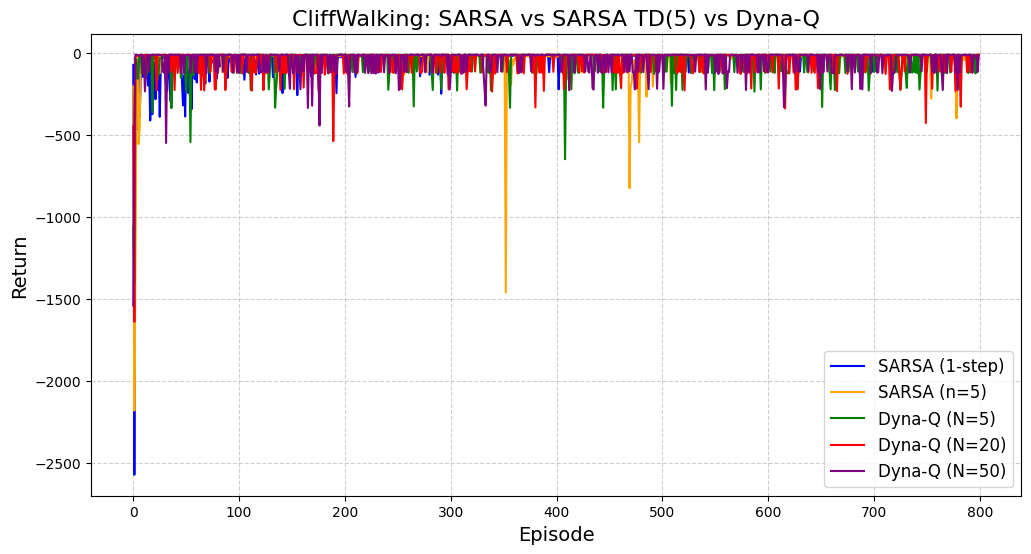

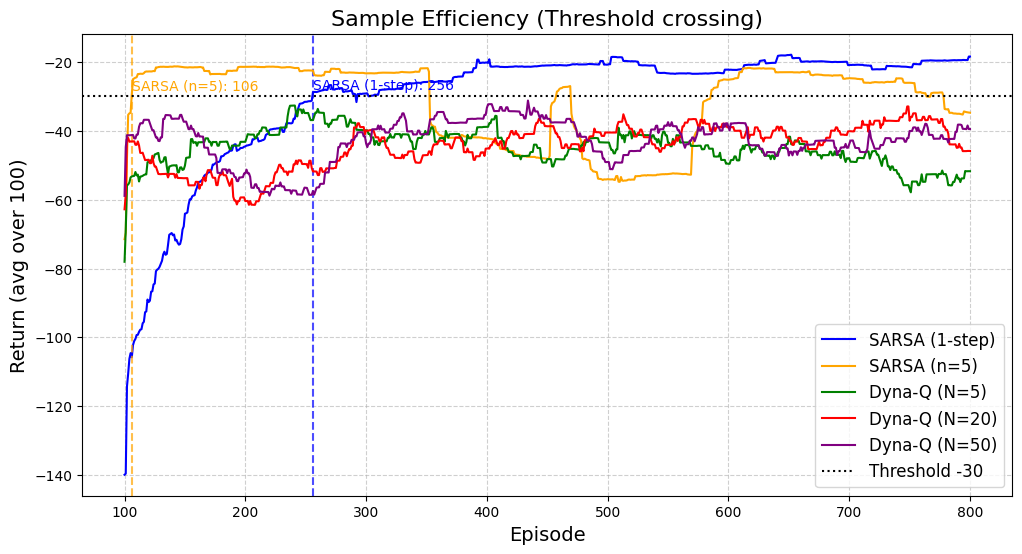

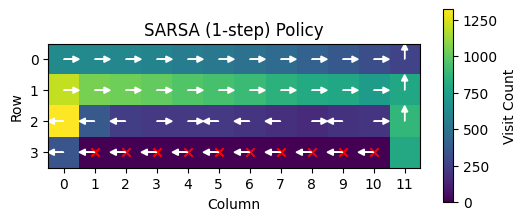

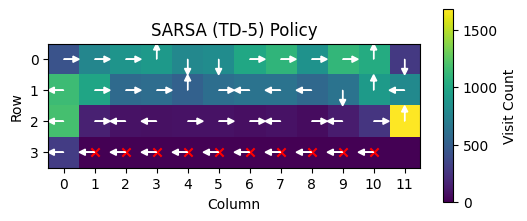

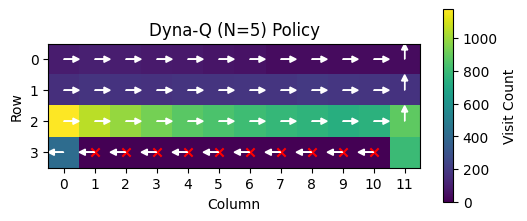

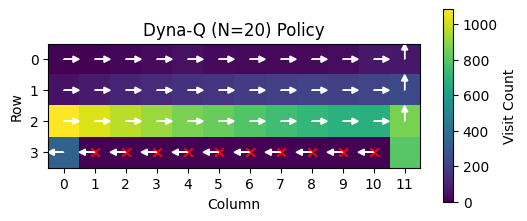

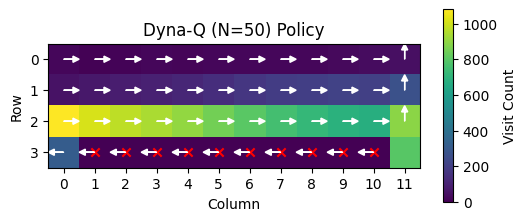

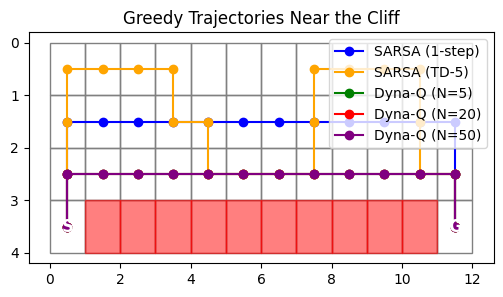

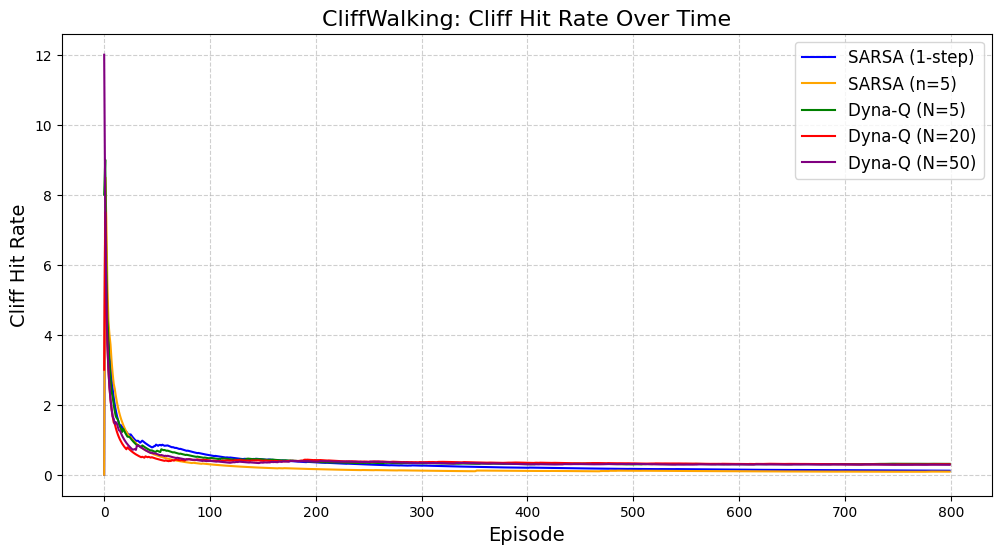

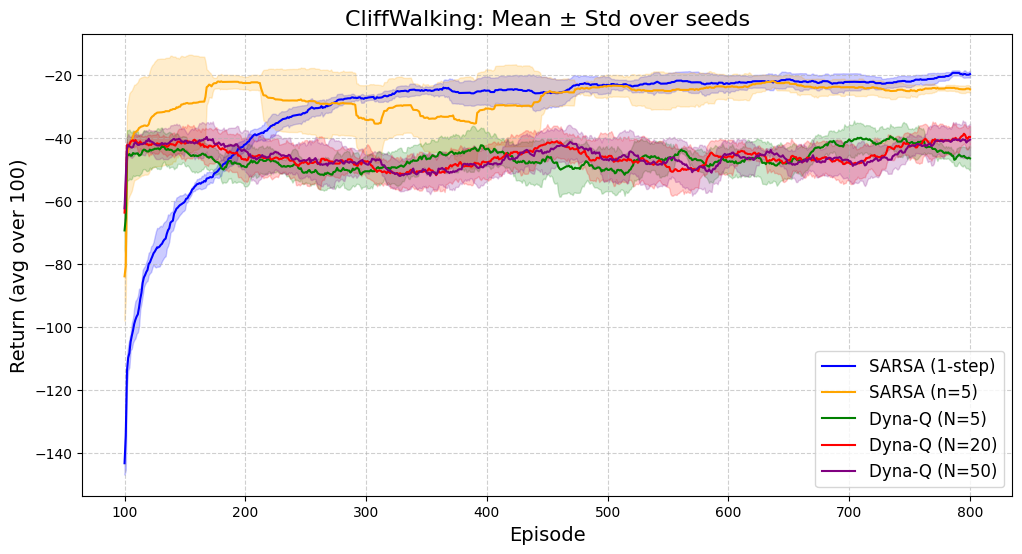

In [17]:
import numpy as np
import gym
import matplotlib.pyplot as plt
import random


N_ROWS, N_COLS = 4, 12

def state_to_rc(state):
    """Convert state index to row, col in grid."""
    return divmod(state, N_COLS)


def epsilon_greedy(Q, state, n_actions, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(n_actions)
    return np.argmax(Q[state])


def run_sarsa(env, alpha, gamma, epsilon, n_episodes):
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    Q = np.zeros((n_states, n_actions))
    returns, hits = [], []
    visits = np.zeros((N_ROWS, N_COLS))

    for ep in range(n_episodes):
        state = env.reset()
        if isinstance(state, tuple):
            state, _ = state
        action = epsilon_greedy(Q, state, n_actions, epsilon)
        done = False
        ep_return, cliff_hits = 0, 0

        while not done:
            step_out = env.step(action)
            if len(step_out) == 5:
                next_state, reward, terminated, truncated, _ = step_out
            else:
                next_state, reward, done_flag, _ = step_out
                terminated, truncated = done_flag, False
            done = terminated or truncated

            next_action = epsilon_greedy(Q, next_state, n_actions, epsilon)
            Q[state, action] += alpha * (
                reward + gamma * Q[next_state, next_action] - Q[state, action]
            )
            state, action = next_state, next_action
            ep_return += reward
            if reward == -100:
                cliff_hits += 1

            r, c = state_to_rc(state)
            visits[r, c] += 1

        returns.append(ep_return)
        hits.append(cliff_hits)
    return np.array(returns), np.array(hits), Q, visits


def run_sarsa_n(env, alpha, gamma, epsilon, n_episodes, n_step=5):
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    Q = np.zeros((n_states, n_actions))
    returns, hits = [], []
    visits = np.zeros((N_ROWS, N_COLS))

    for ep in range(n_episodes):
        state = env.reset()
        if isinstance(state, tuple):
            state, _ = state
        action = epsilon_greedy(Q, state, n_actions, epsilon)

        states, actions, rewards = [state], [action], [0]
        T = float("inf")
        t = 0
        ep_return, cliff_hits = 0, 0

        while True:
            if t < T:
                step_out = env.step(action)
                if len(step_out) == 5:
                    next_state, reward, terminated, truncated, _ = step_out
                else:
                    next_state, reward, done_flag, _ = step_out
                    terminated, truncated = done_flag, False
                done = terminated or truncated

                states.append(next_state)
                rewards.append(reward)
                ep_return += reward
                if reward == -100:
                    cliff_hits += 1

                if done:
                    T = t + 1
                else:
                    next_action = epsilon_greedy(Q, next_state, n_actions, epsilon)
                    actions.append(next_action)
                    state, action = next_state, next_action

                r, c = state_to_rc(state)
                visits[r, c] += 1

            tau = t - n_step + 1
            if tau >= 0:
                G = 0.0
                for i in range(tau + 1, min(tau + n_step, T) + 1):
                    G += (gamma ** (i - tau - 1)) * rewards[i]
                if tau + n_step < T:
                    s_tau_n = states[tau + n_step]
                    a_tau_n = actions[tau + n_step]
                    G += (gamma ** n_step) * Q[s_tau_n, a_tau_n]
                Q[states[tau], actions[tau]] += alpha * (
                    G - Q[states[tau], actions[tau]]
                )

            if tau == T - 1:
                break
            t += 1
        returns.append(ep_return)
        hits.append(cliff_hits)
    return np.array(returns), np.array(hits), Q, visits


def run_dyna_q(env, alpha, gamma, epsilon, n_episodes, n_planning=20):
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    Q = np.zeros((n_states, n_actions))
    model = {}  # (s,a) -> (r,s')
    returns, hits = [], []
    visits = np.zeros((N_ROWS, N_COLS))

    for ep in range(n_episodes):
        state = env.reset()
        if isinstance(state, tuple):
            state, _ = state
        done = False
        ep_return, cliff_hits = 0, 0

        while not done:
            action = epsilon_greedy(Q, state, n_actions, epsilon)
            step_out = env.step(action)
            if len(step_out) == 5:
                next_state, reward, terminated, truncated, _ = step_out
            else:
                next_state, reward, done_flag, _ = step_out
                terminated, truncated = done_flag, False
            done = terminated or truncated
            ep_return += reward
            if reward == -100:
                cliff_hits += 1

            # Real Q-learning update
            Q[state, action] += alpha * (
                reward + gamma * np.max(Q[next_state]) - Q[state, action]
            )

            # Update model
            model[(state, action)] = (reward, next_state)

            # Planning updates
            if model:
                for _ in range(n_planning):
                    s_p, a_p = random.choice(list(model.keys()))
                    r_p, s_next_p = model[(s_p, a_p)]
                    Q[s_p, a_p] += alpha * (
                        r_p + gamma * np.max(Q[s_next_p]) - Q[s_p, a_p]
                    )

            state = next_state
            r, c = state_to_rc(state)
            visits[r, c] += 1

        returns.append(ep_return)
        hits.append(cliff_hits)
    return np.array(returns), np.array(hits), Q, visits


def moving_average(x, window=100):
    return np.convolve(x, np.ones(window)/window, mode="valid")


def find_threshold_crossing(rewards, threshold=-30, window=100):
    avg = moving_average(rewards, window)
    for i, val in enumerate(avg):
        if val >= threshold:
            return i + window
    return None


def plot_sample_efficiency(all_rewards, labels, colors, threshold=-30, window=100):
    plt.figure(figsize=(12,6))
    for rewards, label, color in zip(all_rewards, labels, colors):
        avg = moving_average(rewards, window)
        plt.plot(range(window, len(rewards)+1), avg, label=label, color=color)

        cross = find_threshold_crossing(rewards, threshold, window)
        if cross:
            plt.axvline(cross, color=color, linestyle="--", alpha=0.7)
            plt.text(cross, threshold+2, f"{label}: {cross}", color=color)

    plt.axhline(threshold, color="black", linestyle=":", label=f"Threshold {threshold}")
    plt.xlabel("Episode", fontsize=14)
    plt.ylabel(f"Return (avg over {window})", fontsize=14)
    plt.title("Sample Efficiency (Threshold crossing)", fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()


def plot_policy_heatmap(Q, visits, title="Policy Heatmap"):
    plt.figure(figsize=(6, 2.5))
    plt.imshow(visits, cmap="viridis", origin="upper")
    plt.colorbar(label="Visit Count")
    plt.xticks(range(N_COLS))
    plt.yticks(range(N_ROWS))
    plt.title(title)

    # Draw cliff cells
    for c in range(1, 11):
        plt.scatter(c, 3, marker="x", color="red")

    action_arrows = {
        0: (0, -0.3),   # LEFT
        1: (0, 0.3),    # RIGHT
        2: (-0.3, 0),   # UP
        3: (0.3, 0)     # DOWN
    }

    for s in range(N_ROWS * N_COLS):
        r, c = state_to_rc(s)
        if (r, c) == (3, 11):  # goal
            continue
        a = np.argmax(Q[s])
        dr, dc = action_arrows[a]
        plt.arrow(c, r, dc, dr, head_width=0.2, head_length=0.2, fc="white", ec="white")

    plt.xlabel("Column")
    plt.ylabel("Row")
    plt.show()


def rollout_greedy(env, Q, max_steps=100):
    state = env.reset()
    if isinstance(state, tuple):
        state, _ = state
    path = [state_to_rc(state)]
    for _ in range(max_steps):
        action = np.argmax(Q[state])
        step_out = env.step(action)
        if len(step_out) == 5:
            next_state, _, terminated, truncated, _ = step_out
        else:
            next_state, _, done_flag, _ = step_out
            terminated, truncated = done_flag, False
        path.append(state_to_rc(next_state))
        state = next_state
        if terminated or truncated:
            break
    return path


def plot_trajectories(env, Q_list, labels, colors, title="Greedy Trajectories"):
    plt.figure(figsize=(6, 3))
    for r in range(N_ROWS):
        for c in range(N_COLS):
            plt.gca().add_patch(plt.Rectangle((c, r), 1, 1, fill=False, edgecolor="gray"))
    for c in range(1, 11):
        plt.gca().add_patch(plt.Rectangle((c, 3), 1, 1, color="red", alpha=0.5))
    plt.text(0.5, 3.5, "S", ha="center", va="center", fontsize=12, color="white", weight="bold")
    plt.text(11.5, 3.5, "G", ha="center", va="center", fontsize=12, color="white", weight="bold")

    for Q, label, color in zip(Q_list, labels, colors):
        path = rollout_greedy(env, Q)
        xs = [c+0.5 for r, c in path]
        ys = [r+0.5 for r, c in path]
        plt.plot(xs, ys, marker="o", color=color, label=label)

    plt.gca().invert_yaxis()
    plt.legend()
    plt.title(title)
    plt.show()


def plot_cliff_hits(all_hits, labels, colors):
    plt.figure(figsize=(12,6))
    for hits, label, color in zip(all_hits, labels, colors):
        rate = np.cumsum(hits) / (np.arange(len(hits)) + 1)
        plt.plot(rate, label=label, color=color)
    plt.xlabel("Episode", fontsize=14)
    plt.ylabel("Cliff Hit Rate", fontsize=14)
    plt.title("CliffWalking: Cliff Hit Rate Over Time", fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()


def run_multiple_seeds(run_func, env_name, seeds, *args, **kwargs):
    """Run an algorithm across multiple seeds and collect episode rewards."""
    all_rewards = []
    for seed in seeds:
        env = gym.make(env_name)
        env.reset(seed=seed)
        np.random.seed(seed)
        random.seed(seed)
        rewards, _, _, _ = run_func(env, *args, **kwargs)
        all_rewards.append(rewards)
        env.close()
    return np.array(all_rewards)


def plot_with_shaded(all_rewards_list, labels, colors, window=100):
    """Plot mean ± std shaded curves from multiple seeds."""
    plt.figure(figsize=(12, 6))
    for rewards, label, color in zip(all_rewards_list, labels, colors):
        smoothed = [moving_average(r, window) for r in rewards]
        min_len = min(len(s) for s in smoothed)
        smoothed = np.array([s[:min_len] for s in smoothed])

        mean = smoothed.mean(axis=0)
        std = smoothed.std(axis=0)
        x = np.arange(window, window + len(mean))

        plt.plot(x, mean, label=label, color=color)
        plt.fill_between(x, mean - std, mean + std, color=color, alpha=0.2)

    plt.xlabel("Episode", fontsize=14)
    plt.ylabel(f"Return (avg over {window})", fontsize=14)
    plt.title("CliffWalking: Mean ± Std over seeds", fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()


if __name__ == "__main__":
    env = gym.make("CliffWalking-v0")

    alpha, gamma, epsilon = 0.1, 0.99, 0.1
    n_episodes = 800

    rewards_sarsa, hits_sarsa, Q_sarsa, visits_sarsa = run_sarsa(env, alpha, gamma, epsilon, n_episodes)
    rewards_sarsa5, hits_sarsa5, Q_sarsa5, visits_sarsa5 = run_sarsa_n(env, alpha, gamma, epsilon, n_episodes, n_step=5)
    rewards_dyna5, hits_dyna5, Q_dyna5, visits_dyna5 = run_dyna_q(env, alpha, gamma, epsilon, n_episodes, n_planning=5)
    rewards_dyna20, hits_dyna20, Q_dyna20, visits_dyna20 = run_dyna_q(env, alpha, gamma, epsilon, n_episodes, n_planning=20)
    rewards_dyna50, hits_dyna50, Q_dyna50, visits_dyna50 = run_dyna_q(env, alpha, gamma, epsilon, n_episodes, n_planning=50)

    plt.figure(figsize=(12, 6))
    plt.plot(rewards_sarsa, label="SARSA (1-step)", color="blue")
    plt.plot(rewards_sarsa5, label="SARSA (n=5)", color="orange")
    plt.plot(rewards_dyna5, label="Dyna-Q (N=5)", color="green")
    plt.plot(rewards_dyna20, label="Dyna-Q (N=20)", color="red")
    plt.plot(rewards_dyna50, label="Dyna-Q (N=50)", color="purple")
    plt.xlabel("Episode", fontsize=14)
    plt.ylabel("Return", fontsize=14)
    plt.title("CliffWalking: SARSA vs SARSA TD(5) vs Dyna-Q", fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

    plot_sample_efficiency(
        [rewards_sarsa, rewards_sarsa5, rewards_dyna5, rewards_dyna20, rewards_dyna50],
        ["SARSA (1-step)", "SARSA (n=5)", "Dyna-Q (N=5)", "Dyna-Q (N=20)", "Dyna-Q (N=50)"],
        ["blue", "orange", "green", "red", "purple"],
        threshold=-30,
        window=100
    )

    plot_policy_heatmap(Q_sarsa, visits_sarsa, "SARSA (1-step) Policy")
    plot_policy_heatmap(Q_sarsa5, visits_sarsa5, "SARSA (TD-5) Policy")
    plot_policy_heatmap(Q_dyna5, visits_dyna5, "Dyna-Q (N=5) Policy")
    plot_policy_heatmap(Q_dyna20, visits_dyna20, "Dyna-Q (N=20) Policy")
    plot_policy_heatmap(Q_dyna50, visits_dyna50, "Dyna-Q (N=50) Policy")

    plot_trajectories(
        env,
        [Q_sarsa, Q_sarsa5, Q_dyna5, Q_dyna20, Q_dyna50],
        ["SARSA (1-step)", "SARSA (TD-5)", "Dyna-Q (N=5)", "Dyna-Q (N=20)", "Dyna-Q (N=50)"],
        ["blue", "orange", "green", "red", "purple"],
        title="Greedy Trajectories Near the Cliff"
    )

    plot_cliff_hits(
        [hits_sarsa, hits_sarsa5, hits_dyna5, hits_dyna20, hits_dyna50],
        ["SARSA (1-step)", "SARSA (n=5)", "Dyna-Q (N=5)", "Dyna-Q (N=20)", "Dyna-Q (N=50)"],
        ["blue", "orange", "green", "red", "purple"]
    )

    seeds = [0, 1, 2, 3, 4]

    rewards_sarsa_all = run_multiple_seeds(run_sarsa, "CliffWalking-v0", seeds,
                                           alpha, gamma, epsilon, n_episodes)
    rewards_sarsa5_all = run_multiple_seeds(run_sarsa_n, "CliffWalking-v0", seeds,
                                            alpha, gamma, epsilon, n_episodes, n_step=5)
    rewards_dyna5_all = run_multiple_seeds(run_dyna_q, "CliffWalking-v0", seeds,
                                           alpha, gamma, epsilon, n_episodes, n_planning=5)
    rewards_dyna20_all = run_multiple_seeds(run_dyna_q, "CliffWalking-v0", seeds,
                                            alpha, gamma, epsilon, n_episodes, n_planning=20)
    rewards_dyna50_all = run_multiple_seeds(run_dyna_q, "CliffWalking-v0", seeds,
                                            alpha, gamma, epsilon, n_episodes, n_planning=50)

    plot_with_shaded(
        [rewards_sarsa_all, rewards_sarsa5_all, rewards_dyna5_all,
         rewards_dyna20_all, rewards_dyna50_all],
        ["SARSA (1-step)", "SARSA (n=5)",
         "Dyna-Q (N=5)", "Dyna-Q (N=20)", "Dyna-Q (N=50)"],
        ["blue", "orange", "green", "red", "purple"],
        window=100
    )

    env.close()



## Exercise 3: Solve FrozenLake with Q-Learning and Dyna-Q (Stochastic Model)

**Objective**  
Implement and compare **Q-learning** and **Dyna-Q** on Gymnasium’s `FrozenLake-v1`.  
For Dyna-Q, your learned **transition model must handle multiple possible next states** per `(s, a)` (stochastic slip), i.e., store and sample **a distribution** over `(s', r)` outcomes rather than a single next state.

---

### Environment
- Use `FrozenLake-v1` from `gymnasium.envs.toy_text`.
- You can start with map 4×4; and then work with 8×8.
- Start → Goal with slippery transitions (stochastic).  
- Rewards: `+1` at goal, `0` otherwise (holes terminate with 0).

---

### Part A — Q-learning (baseline)
1. Maintain a tabular action-value function `Q[s, a]`.
2. Behavior: ε-greedy over `Q`.
3. Update after each real step:
   - target = r + γ * max_a' Q[s', a']   (if terminal: target = r)
   - Q[s, a] ← Q[s, a] + α * (target − Q[s, a])
4. Train for several thousand episodes (e.g., 5,000) with an ε schedule (e.g., 0.2 → 0.01).

---

### Part B — Dyna-Q with a **stochastic transition model**
1. **Empirical model (multinomial):** for each `(s, a)`, maintain a multiset of observed outcomes:
   - `model[(s, a)] = [(s'_1, r_1, count_1), (s'_2, r_2, count_2), ...]`
   - Update counts whenever you observe `(s, a, r, s')`.
2. **Real step update (Q-learning):** same as Part A.
3. **Planning steps (N per real step):**
   - Sample a previously seen `(s_p, a_p)` uniformly (or with priority).
   - Sample `(s'_p, r_p)` **from the empirical distribution** for `(s_p, a_p)` using counts as probabilities.
   - Apply the same Q-learning backup with `(s_p, a_p, r_p, s'_p)`.
4. Train with the same ε schedule and number of episodes; vary `N ∈ {5, 20, 50}`.

---

### Experiments & Analysis
1. **Learning curves:** plot episode index vs episode return (smoothed) for:
   - Q-learning
   - Dyna-Q (N=5, 20, 50)
2. **Sample efficiency:** report the episode at which the moving-average return (e.g., window 100) first exceeds a threshold (you choose a reasonable value).
3. **Effect of stochastic modeling:** briefly explain why storing a distribution over `(s', r)` matters on FrozenLake (slip), and what happens if you store only the most recent outcome.
4. **Robustness:** run ≥5 random seeds; report mean ± std of final evaluation returns.

---

### Deliverables
- **Code** for Q-learning and Dyna-Q (with stochastic model).  
- **Plots** of learning curves (include legend and axis labels).  
- ** Discussion:** why Dyna-Q helps here; impact of N; importance of modeling multiple next states.

---

### Hints
- For terminal transitions (goal/hole), the Q-learning target is simply `target = r` (no bootstrap).  
- When sampling from the model, use probabilities `p_i = count_i / sum_j count_j`.  
- Tie-break greedy action selection uniformly among argmax actions to avoid bias.  
- Keep evaluation **greedy (ε=0)** and consistent across methods (same seeds and episode counts).


In [ ]:
import numpy as np
import gym
import matplotlib.pyplot as plt
import random
from collections import defaultdict

ENV_ID   = "FrozenLake-v1"
MAP_NAME = "4x4"
IS_SLIPPERY = True

GAMMA = 0.99
ALPHA = 0.8
EPS_START, EPS_END = 0.20, 0.01
EPISODES = 5000
SEEDS = [0,1,2,3,4]
MA_WINDOW = 100
THRESHOLD = 0.6 if MAP_NAME == "4x4" else 0.2
EVAL_EPISODES = 200
PLANNING_SET = [5, 20, 50]

def make_env(seed=None):
    env = gym.make(ENV_ID, is_slippery=IS_SLIPPERY, map_name=MAP_NAME, render_mode = "human")
    if seed is not None:
        try:
            env.reset(seed=seed)
        except TypeError:
            env.seed(seed)
    return env

def epsilon_schedule(t, T, eps_start=EPS_START, eps_end=EPS_END):
    frac = max(0.0, 1 - t / T)
    return eps_end + (eps_start - eps_end) * frac

def argmax_tie_break(q_row):
    max_val = np.max(q_row)
    idxs = np.flatnonzero(q_row == max_val)
    return np.random.choice(idxs)

def eps_greedy_action(Q, s, eps):
    if np.random.rand() < eps:
        return np.random.randint(Q.shape[1])
    return argmax_tie_break(Q[s])

def moving_average(x, window=MA_WINDOW):
    if len(x) < window:
        return np.array([])
    return np.convolve(x, np.ones(window)/window, mode="valid")

def step_env(env, action):
    out = env.step(action)
    if len(out) == 5:
        ns, r, terminated, truncated, info = out
        done = terminated or truncated
    else:
        ns, r, done, info = out
    return ns, r, done

def reset_env(env):
    out = env.reset()
    if isinstance(out, tuple):
        s, info = out
        return s
    return out

def run_q_learning(env, alpha, gamma, episodes, eps_start, eps_end):
    nS = env.observation_space.n
    nA = env.action_space.n
    Q = np.zeros((nS, nA), dtype=np.float32)
    ep_returns = []
    for ep in range(episodes):
        s = reset_env(env)
        done = False
        R = 0.0
        eps = epsilon_schedule(ep, episodes, eps_start, eps_end)
        while not done:
            a = eps_greedy_action(Q, s, eps)
            ns, r, done = step_env(env, a)
            target = r if done else r + gamma * np.max(Q[ns])
            Q[s, a] += alpha * (target - Q[s, a])
            s = ns
            R += r
        ep_returns.append(R)
    return np.array(ep_returns), Q

class StochasticModel:
    def __init__(self):
        self.outcomes = defaultdict(lambda: defaultdict(int))
        self.totals = defaultdict(int)
        self._pairs = None
        self._weights = None
        self._dirty = True
    def update(self, s, a, ns, r, done):
        self.outcomes[(s,a)][(ns, r, done)] += 1
        self.totals[(s,a)] += 1
        self._dirty = True
    def _refresh(self):
        if self._dirty:
            self._pairs = list(self.totals.keys())
            w = np.array([self.totals[k] for k in self._pairs], dtype=np.float64)
            self._weights = w / w.sum()
            self._dirty = False
    def sample_pair(self):
        self._refresh()
        i = np.random.choice(len(self._pairs), p=self._weights)
        return self._pairs[i]
    def sample_outcome(self, s, a):
        d = self.outcomes[(s,a)]
        keys = list(d.keys())
        counts = np.array([d[k] for k in keys], dtype=np.float64)
        probs = counts / counts.sum()
        i = np.random.choice(len(keys), p=probs)
        return keys[i]  # (ns, r, done)

def run_dyna_q_stochastic(env, alpha, gamma, episodes, eps_start, eps_end, n_planning, alpha_plan=None):
    nS = env.observation_space.n
    nA = env.action_space.n
    Q = np.zeros((nS, nA), dtype=np.float32)
    model = StochasticModel()
    if alpha_plan is None:
        alpha_plan = 0.25 * alpha
    ep_returns = []
    for ep in range(episodes):
        s = reset_env(env)
        done = False
        R = 0.0
        eps = epsilon_schedule(ep, episodes, eps_start, eps_end)
        while not done:
            a = eps_greedy_action(Q, s, eps)
            ns, r, done = step_env(env, a)
            target = r if done else r + gamma * np.max(Q[ns])
            Q[s, a] += alpha * (target - Q[s, a])
            model.update(s, a, ns, r, done)
            if model.totals:
                for _ in range(n_planning):
                    sp, ap = model.sample_pair()
                    nsp, rp, dp = model.sample_outcome(sp, ap)
                    t = rp if dp else rp + gamma * np.max(Q[nsp])
                    Q[sp, ap] += alpha_plan * (t - Q[sp, ap])
            s = ns
            R += r
        ep_returns.append(R)
    return np.array(ep_returns), Q

def evaluate_policy(env, Q, n_episodes=EVAL_EPISODES):
    total = 0.0
    for _ in range(n_episodes):
        s = reset_env(env)
        done = False
        while not done:
            a = argmax_tie_break(Q[s])
            ns, r, done = step_env(env, a)
            s = ns
            total += r
    return total / n_episodes

def run_seeds_qlearning(seeds, **kwargs):
    all_returns = []
    Q_last = []
    for sd in seeds:
        np.random.seed(sd); random.seed(sd)
        env = make_env(seed=sd)
        returns, Q = run_q_learning(env, **kwargs)
        env.close()
        all_returns.append(returns)
        Q_last.append(Q)
    return np.array(all_returns), Q_last

def run_seeds_dynaq(seeds, n_planning, **kwargs):
    all_returns = []
    Q_last = []
    for sd in seeds:
        np.random.seed(sd); random.seed(sd)
        env = make_env(seed=sd)
        returns, Q = run_dyna_q_stochastic(env, n_planning=n_planning, **kwargs)
        env.close()
        all_returns.append(returns)
        Q_last.append(Q)
    return np.array(all_returns), Q_last

def plot_learning_curves_shaded(runs_list, labels, colors, window=MA_WINDOW, title="Learning Curves"):
    plt.figure(figsize=(12,6))
    for runs, lab, col in zip(runs_list, labels, colors):
        smoothed = [moving_average(r, window) for r in runs]
        if any(len(s)==0 for s in smoothed):
            smoothed = [np.array(r) for r in runs]
            min_len = min(len(s) for s in smoothed)
            smoothed = np.array([s[:min_len] for s in smoothed])
            x = np.arange(min_len)
        else:
            min_len = min(len(s) for s in smoothed)
            smoothed = np.array([s[:min_len] for s in smoothed])
            x = np.arange(window, window + min_len)
        mean = smoothed.mean(axis=0)
        std  = smoothed.std(axis=0)
        plt.plot(x, mean, label=lab, color=col)
        plt.fill_between(x, mean-std, mean+std, color=col, alpha=0.2)
    plt.xlabel("Episode")
    plt.ylabel(f"Return (smoothed, w={window})")
    plt.title(title)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

def find_threshold_crossing_curve(rewards, threshold=THRESHOLD, window=MA_WINDOW):
    ma = moving_average(rewards, window)
    for i, v in enumerate(ma):
        if v >= threshold:
            return i + window
    return None

def report_sample_efficiency(all_runs, labels, threshold=THRESHOLD, window=MA_WINDOW):
    print("\n=== Sample Efficiency ===")
    for runs, lab in zip(all_runs, labels):
        crossings = []
        for r in runs:
            c = find_threshold_crossing_curve(r, threshold, window)
            if c is not None:
                crossings.append(c)
        if crossings:
            print(f"{lab:>16}: mean={np.mean(crossings):.1f} ± {np.std(crossings):.1f} (n={len(crossings)}/{len(runs)})")
        else:
            print(f"{lab:>16}: never crossed (n=0/{len(runs)})")

def bar_final_eval(eval_means, eval_stds, labels, title="Final Evaluation"):
    plt.figure(figsize=(8,5))
    x = np.arange(len(labels))
    plt.bar(x, eval_means, yerr=eval_stds, capsize=6)
    plt.xticks(x, labels, rotation=15)
    plt.ylabel("Average return")
    plt.title(title)
    plt.ylim(0, 1.05)
    plt.grid(True, axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    q_runs, q_Qs = run_seeds_qlearning(
        SEEDS, alpha=ALPHA, gamma=GAMMA, episodes=EPISODES,
        eps_start=EPS_START, eps_end=EPS_END
    )
    dynaq_runs = []
    dynaq_Qs_all = []
    for N in PLANNING_SET:
        runs, Qs = run_seeds_dynaq(
            SEEDS, n_planning=N, alpha=ALPHA, gamma=GAMMA,
            episodes=EPISODES, eps_start=EPS_START, eps_end=EPS_END
        )
        dynaq_runs.append(runs)
        dynaq_Qs_all.append(Qs)
    runs_list = [q_runs] + dynaq_runs
    labels = ["Q-learning"] + [f"Dyna-Q (N={N})" for N in PLANNING_SET]
    colors = ["black", "green", "red", "purple"]
    plot_learning_curves_shaded(
        runs_list, labels, colors,
        window=MA_WINDOW,
        title=f"FrozenLake {MAP_NAME} — Learning Curves"
    )
    report_sample_efficiency(runs_list, labels, threshold=THRESHOLD, window=MA_WINDOW)
    eval_means, eval_stds = [], []
    for Qs, lab in zip([q_Qs] + dynaq_Qs_all, labels):
        scores = []
        for sd, Q in zip(SEEDS, Qs):
            env = make_env(seed=sd+12345)
            score = evaluate_policy(env, Q, n_episodes=EVAL_EPISODES)
            env.close()
            scores.append(score)
        eval_means.append(np.mean(scores))
        eval_stds.append(np.std(scores))
        print(f"{lab:>16}: {np.mean(scores):.3f} ± {np.std(scores):.3f}")
    bar_final_eval(eval_means, eval_stds, labels,
                   title=f"FrozenLake {MAP_NAME} — Final Eval")
